In [ ]:
import numpy as np 
import os
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout,MaxPool2D, LSTM, GRU, BatchNormalization,Input
from tensorflow.keras.layers import Embedding, concatenate, Reshape,Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import ELU
import random

from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import mobilenet_v2
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import keras.optimizers
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import files

In [ ]:
from google.colab import drive
from pathlib import Path
import sys
drive.mount('/content/drive', force_remount=True)
base = Path('/content/drive/MyDrive')
sys.path.append(str(base))

zip_path = base/'RiceFinal.zip'

!cp {zip_path} .

!unzip -q RiceFinal.zip

!rm RiceFinal.zip

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/RiceFinal/full.csv')
train_path = '/content/RiceFinal/train'
test_path = '/content/RiceFinal/test'
validation_path = '/content/RiceFinal/val'

# 1 Abstract

Accurate diagnosis of rice disease is crucial for correct treatment. However, rural rice-growing regions in India and southeast Asia often rely on individuals specialized in the growing of rice. Such a dependency is inefficient, as the avaiability of any such person is highly limited, especially if it is necessary to examine vast paddies of rice. A misdiagnosis or an unexamined plant can prove costly in the long run, especially if the diseased plant begins infecting its neighbors, causing large drops in yield. This paper explores the application of machine learning processes for the automatic detection and diagnosing of rice plant diseases. The model was trained, validated, and tested on a dataset of approximately 10,000 images of 10 classes, with one class representing healthy rice plants, and the other 9 representing 4 main archetypes of disease: bacterial, fungal, viral, and insect-caused. More specifically, the diseases include the top 9 most common rice diseases: leaf blight, leaf streak, panicle blight, blast, hispa, tungro, dead heart, brown spot, and downy mildew. The diagnosis method utilized the MobileNetV2 architecture, due to its computational efficiency and lightweight structure. This model was able to achieve 97.6% accuracy on the test set of images. This is a satisfactory performance, due especially to the fact that some diseases appear similar.

# 2 Introduction

Rice is one of the most important food energy sources in the world. It is a complex carbohydrate that contains multitudes of beneficial micronutrients, including B vitamins, potassium, folic acid, fiber, iron, zinc and magnesium [[1]](https://www.usarice.com/thinkrice/health-nutrition/rice-nutrition). More than half of the world's population depends on rice daily as a staple food. As a result, it is grown in more than 100 countries, with approximately 90% of the total worldwide production coming from Asia [[2]](https://pubmed.ncbi.nlm.nih.gov/31619630/). However, the amount of rice produced by these countries is not completely efficient. Due to numerous diseases - bacterial, viral, or other, yields in rice-growing regions are greatly reduced. Certain rice diseases, can end in the loss of up to 80% of a crop! [[3]](http://www.knowledgebank.irri.org/step-by-step-production/growth/pests-and-diseases/diseases). Often, the symptoms of rice disease appear very similar, and it may be difficult to accurately diagnose the specific disease without use of specialized equipment [[4]](https://plantvillage.psu.edu/topics/rice/infos). As such, it would be practical to employ machine learning concepts for the construction of a neural network capable of automatically detecting and diagnosing disease in rice plants. 

The data used for this paper is taken from the open source 'Paddy Doctor' repository online, where the original dataset is quite a bit larger than what is used for training the model here. The images of healthy and diseased rice plants on the 'Paddy Doctor' website are taken from Pallamadai Village in Tamil Nadu, India. The smaller dataset used in this paper has 9 diseases, all of which are not unique to Southern India [[5]](https://www.intechopen.com/chapters/79212). This allows for the model to be applicable to other rice-growing regions, such as Japan, southeast Asia, Australia and Europe [[6]](https://www.ers.usda.gov/topics/crops/rice/rice-sector-at-a-glance/). 

The idea of applying convolutional neural networks to the problem of disease classification is not a new concept by any means [[7]](https://link.springer.com/article/10.1007/s42452-022-05194-7), other research focuses on larger, more through models such as ResNet50, ResNet121 and Vgg-16 and 19. 

Overall, the application of machine learning to the diagnosis of rice diseases can provide a much needed boost in the efficacy of treatment and early prevention of diseases that would otherwise cause massive loss in yield volume.

However, there are three specific problems that may affect the capacity of the neural network in correctly diagnosing diseases. The first  is the concern that synptoms of some diseases in the dataset appear very similar to each other, despite having distinct effects and treatments. The second is that the images are not segmented, so the diseased subjects often blends in with the background and it is hard to distinguish where the disease is. The third is that the images are sometimes blurry - the camera focuses on the background, rather than the diseased subject in the foreground. 


# 2.1 Convolutional Network

This new age approach to image classification has revolutionised the process of diagnosis. Convolutional Neural Networks (CNNs) are able to recognize global patterns in images by continually learning small local patterns and combining them. As a result, CNNs are less susceptible to the exploding gradient issue seen in FCCs (Fully Connected Networks). Further, CNNs are translation invariant, meaning that once they learn a pattern appearing in an image, they will recognize it regardless of where it appears on subsequent images. FCCs must relearn the pattern for every new location, and are thus less efficient than CNNs. 

The architecture of a CNN consists of several important layers briefly discussed below:

Convolutional Layer: The tensor of shape (input height) x (input width) x (input depth). In this case, the depth is color channels in the image (3) representing RGB values. The layer then slides a small kernel (filter window) across the image and captures numerical values associated with each pixel. Due to not being fully connected, the number of parameters is reduced and the network can be used more efficiently on larger images. 

Pooling Layer: The Max Pooling layer seen in the architecture of later sections is a downsampling layer that selects the largest values from each convolution window as the inputs to the next layer. Thus, the pooling layer serves to reduce dimensionality from each neuron cluster before proceding to the next neuron. 

Flattening layer: The Flattening layer compresses the previously computed feature maps int oa 1 dimensional array in order to match the input shape of the following fully connected layer. 

Fully Connected layer: This Neuron connects all neurons of one layer to all neurons of a following layer. This is the output layer of the convolutional Neural Network which will classify the images. 

# 3 Exploratory Data Analysis

In [ ]:
df.head()

image_id                  label variety  age
0  100330.jpg  bacterial_leaf_blight   ADT45   45
1  100365.jpg  bacterial_leaf_blight   ADT45   45
2  100382.jpg  bacterial_leaf_blight   ADT45   45
3  100632.jpg  bacterial_leaf_blight   ADT45   45
4  101918.jpg  bacterial_leaf_blight   ADT45   45

By displaying the top 5 results of our CSV, we see that the data has four variables. 


<p>image_id: The image index associated with the image folder. </p>
<p>label: The type of disease the rice is affected with.
<p>variety: The name of the type of paddy.
<p>age: Age of the paddy.

In [ ]:
len(df)

10407

There are 10,407 observations in the dataset, each with the above 4 variables. 

In [ ]:
df.describe()

age
count  10407.000000
mean      64.043624
std        8.958830
min       45.000000
25%       60.000000
50%       67.000000
75%       70.000000
max       82.000000

Age is the only non-categorical variable. We can see that the average paddy age for this dataset is about 64 days. This suggests that many paddies are either young, or just reaching maturity [[1]](http://www.agritech.tnau.ac.in/expert_system/paddy/TNvarieties.html). Indeed, we see that the maximum paddy age feature in the data is just 82 days. 

In [ ]:
archetype_df = df.copy()
bacterial = ['bacterial_leaf_blight','bacterial_leaf_streak','bacterial_panicle_blight']
fungal = ['blast','brown_spot']
insect = ['hispa','dead_heart']
viral = ['downy_mildew','tungro']

In [ ]:
archetype_df['label'] = archetype_df['label'].replace(bacterial,'bacterial')
archetype_df['label'] = archetype_df['label'].replace(fungal,'fungal')
archetype_df['label'] = archetype_df['label'].replace(insect,'insect')
archetype_df['label'] = archetype_df['label'].replace(viral,'viral')

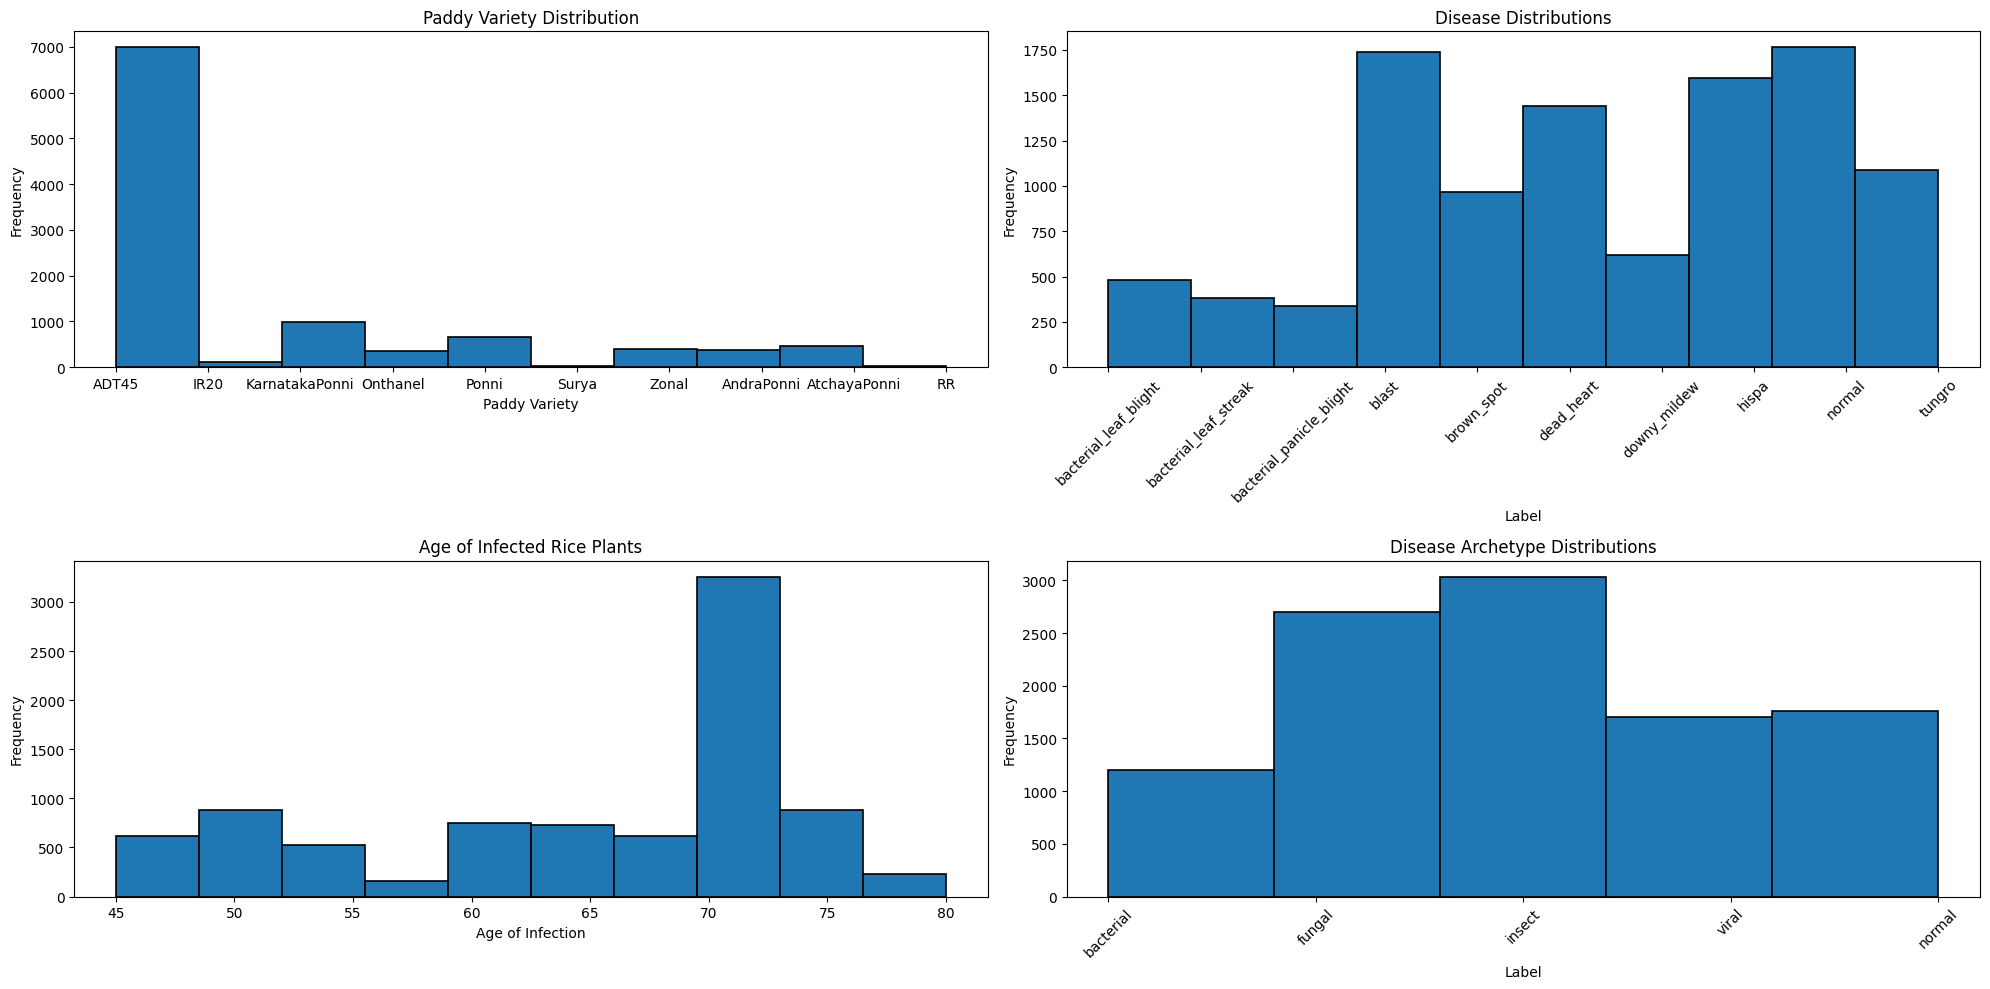

In [ ]:
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2, figsize = (20,10))
ax1.hist(x = df['variety'], bins=10, edgecolor='black', linewidth=1.2)
plt.xticks(rotation = 45)
ax1.set_title('Paddy Variety Distribution')
ax1.set_xlabel('Paddy Variety')
ax1.set_ylabel('Frequency')

ax2.hist(x = df['label'], bins=10, edgecolor='black', linewidth=1.2)
ax2.set_xticklabels(['bacterial_leaf_blight','bacterial_leaf_streak','bacterial_panicle_blight','blast','brown_spot','dead_heart','downy_mildew','hispa','normal','tungro'], rotation=45)
ax2.set_title('Disease Distributions')
ax2.set_xlabel('Label')
ax2.set_ylabel('Frequency')

ax3.hist(df[df['label'] != 'normal']['age'], edgecolor = 'black', linewidth = 1.2)
ax3.set_xlabel('Age of Infection')
ax3.set_ylabel('Frequency')
ax3.set_title('Age of Infected Rice Plants')

ax4.hist(x = archetype_df['label'], bins=5, edgecolor='black', linewidth=1.2)
plt.xticks(rotation = 45)
ax4.set_title('Disease Archetype Distributions')
ax4.set_xlabel('Label')
ax4.set_ylabel('Frequency')

fig.tight_layout()




From the plot, ADT45 is the most prevalent type of paddy in the data. Due to this, it would be pertinent to further examine its statistics. 

In [ ]:
df[df['variety'] == 'ADT45'].describe()

age
count  6992.000000
mean     64.308924
std       8.138329
min      45.000000
25%      60.000000
50%      68.000000
75%      70.000000
max      82.000000

As expected, the amount of ADT45 paddies included greatly influences the summary statistics of the entire dataset. It includes both the minimum and maximum paddy ages (45 and 82 days, respectively). The mean age of the ADT45 paddies also reflects the overall mean at 64.3 days.

Now, examine the types of diseases included.

In [ ]:
print(df['label'].unique())

['bacterial_leaf_blight' 'bacterial_leaf_streak'
 'bacterial_panicle_blight' 'blast' 'brown_spot' 'dead_heart'
 'downy_mildew' 'hispa' 'normal' 'tungro']


There are 10 classes, with 9 of them being diseases and one being healthy rice, represented by the 'normal' label.

In [ ]:
print(df['label'].value_counts())

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64


Across the disease archetypes the classes are more balanced. However, there is a predominance of insect and fungal diseases. This makes sense due to the fact that the warm, humid conditions of rice growing environments are also well-suited for insects. The humidity also provides excellent moisture for the growth of fungi, which explains why it is the second most prominent category. 

In [ ]:
images = ['/content/RiceFinal/train/hispa/100662.jpg',\
          '/content/RiceFinal/train/tungro/103985.jpg',\
          '/content/RiceFinal/train/bacterial_leaf_blight/100330.jpg',\
          '/content/RiceFinal/train/downy_mildew/100017.jpg',\
          '/content/RiceFinal/train/blast/110373.jpg',\
          '/content/RiceFinal/train/bacterial_leaf_streak/100042.jpg',\
          '/content/RiceFinal/train/normal/100002.jpg',\
          '/content/RiceFinal/train/brown_spot/100001.jpg',\
          '/content/RiceFinal/train/dead_heart/105159.jpg',\
          '/content/RiceFinal/train/bacterial_panicle_blight/101351.jpg',\
         ]


diseases = ['hispa','tungro','bacterial_leaf_blight','downy_mildew','blast','bacterial_leaf_streak','normal','brown_spot','dead_heart','bacterial_pannicle_blight']

Below is a collection of labelled images (one from each class in the data) to demonstrate the prominent symptoms of each disease. (These images were handpicked from the data in order to best demonstrate the symptoms. In later sections, images will be randomly selected when data challenges are discussed).

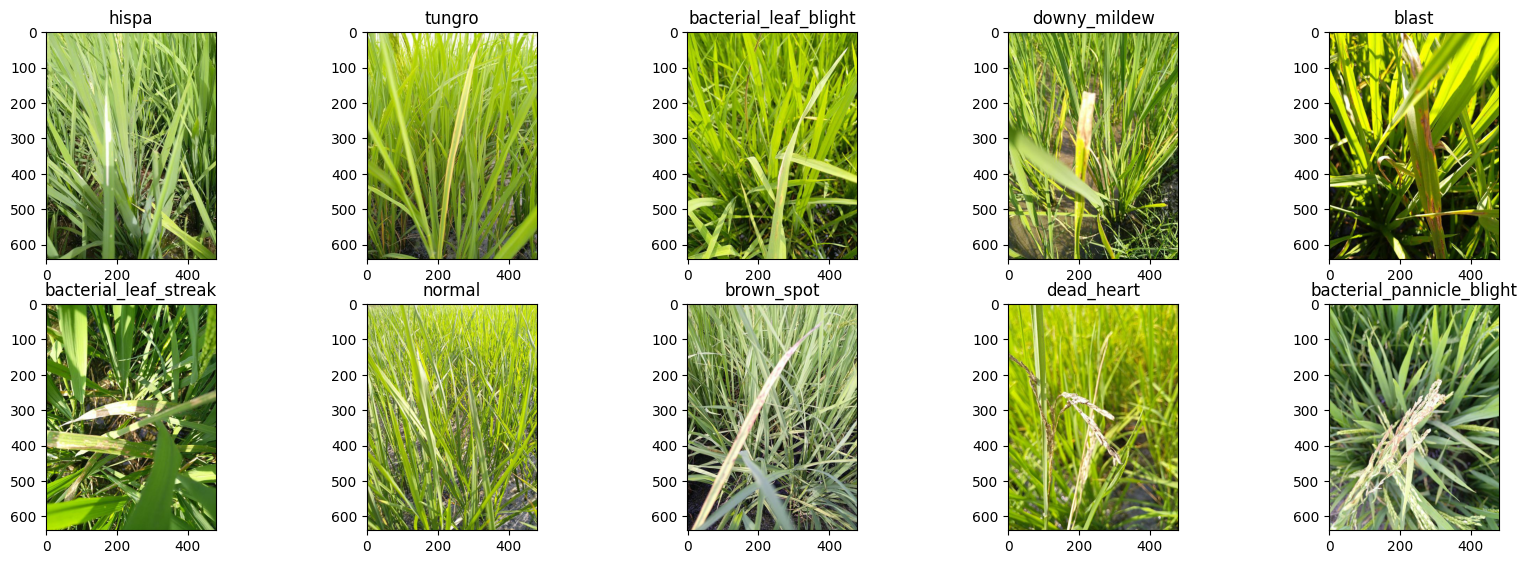

In [ ]:
plt.figure(figsize=(20,10))
cols = 5
for i, image_loc in enumerate(images):
  plt.subplot(len(images)//cols+1,cols,i+1)
  image = plt.imread(image_loc)
  plt.title(diseases[i])
  plt.imshow(image)



# 3.1 Data Challenges 

Based on these images, the challenges discussed previously become apparent. In this section, I will examine the extent to which each challenge affects the data. 

# 3.1.1 Similarities Between Diseases

Several of the diseases in the dataset show similarities to one another. One such pair is Dead Heart and Bacterial Pannicle Blight. Despite being caused by completely different things (insect vs bacterium, respectively), they present with the same symptom - a withered, brittle panicle. (The panicle of rice is the flowering part where the grain grows). For a base examination, I randomly sample 8 images from the training data (4 of each disease) to demonstrate the similarities in appearance. 

In [ ]:
similar_images = []
heart_dir='/content/RiceFinal/train/dead_heart/'
blight_dir='/content/RiceFinal/train/bacterial_panicle_blight/'

heart_list=os.listdir(heart_dir)
blight_list=os.listdir(blight_dir)

i = 0

while i < 4:
  heart_rand_img=random.choice(heart_list)
  heart_rand_img=os.path.join(heart_dir, heart_rand_img)
  similar_images.append(heart_rand_img)
  i += 1

i = 0
while i < 4:

  blight_rand_img=random.choice(blight_list)
  blight_rand_img=os.path.join(blight_dir, blight_rand_img)
  similar_images.append(blight_rand_img)
  i += 1




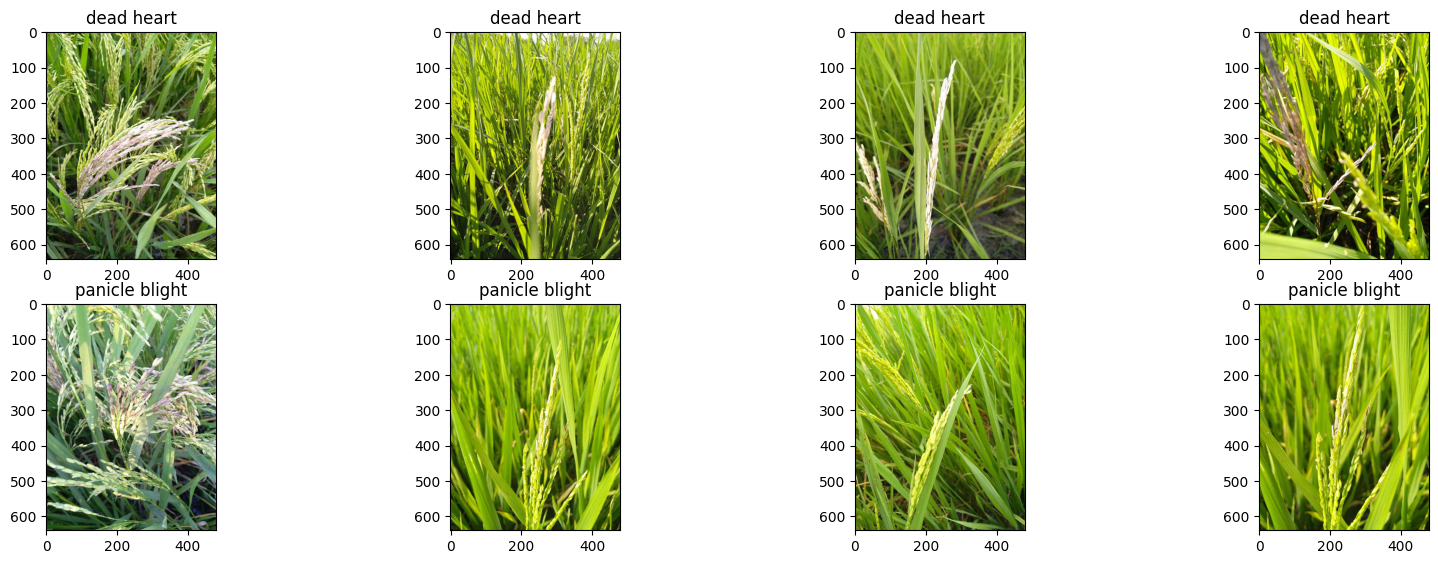

In [ ]:
plt.figure(figsize=(20,10))
diseases = ['dead heart','dead heart','dead heart','dead heart',
            'panicle blight','panicle blight','panicle blight','panicle blight',]
cols = 4
for i, image_loc in enumerate(similar_images):
  plt.subplot(len(similar_images)//cols+1,cols,i+1)
  image = plt.imread(image_loc)
  plt.title(diseases[i])
  plt.imshow(image)

As apparent, to the untrained eye, it may be virtually impossible to distinguish between riceplants affected by these two diseases. The hope is that the algorithm will be able to pick up on differences much more efficiently and accurately than a human would. 

# 3.1.2 Diseased Subject Blending in with Background

As a result of bad photography or minimal symptoms, some diseased subjects blend in with the background to demonstrate, I will randomly sample images from the training dataset. I will not label these image plots, since labels are not relevant to the segmentation concern.

In [ ]:
similar_images = [os.listdir('/content/RiceFinal/train/hispa'),\
          os.listdir('/content/RiceFinal/train/tungro'),\
          os.listdir('/content/RiceFinal/train/bacterial_leaf_blight'),\
          os.listdir('/content/RiceFinal/train/downy_mildew'),\
          os.listdir('/content/RiceFinal/train/blast'),\
          os.listdir('/content/RiceFinal/train/bacterial_leaf_streak'),\
          os.listdir('/content/RiceFinal/train/normal'),\
          os.listdir('/content/RiceFinal/train/brown_spot'),\
          os.listdir('/content/RiceFinal/train/dead_heart'),\
          os.listdir('/content/RiceFinal/train/bacterial_panicle_blight')]

image_paths = ['/content/RiceFinal/train/hispa/',\
          '/content/RiceFinal/train/tungro/',\
          '/content/RiceFinal/train/bacterial_leaf_blight/',\
          '/content/RiceFinal/train/downy_mildew/',\
          '/content/RiceFinal/train/blast/',\
          '/content/RiceFinal/train/bacterial_leaf_streak/',\
          '/content/RiceFinal/train/normal/',\
          '/content/RiceFinal/train/brown_spot/',\
          '/content/RiceFinal/train/dead_heart/',\
          '/content/RiceFinal/train/bacterial_panicle_blight/']


In [ ]:
images = []
for path in similar_images:
  images.append(random.choice(path))

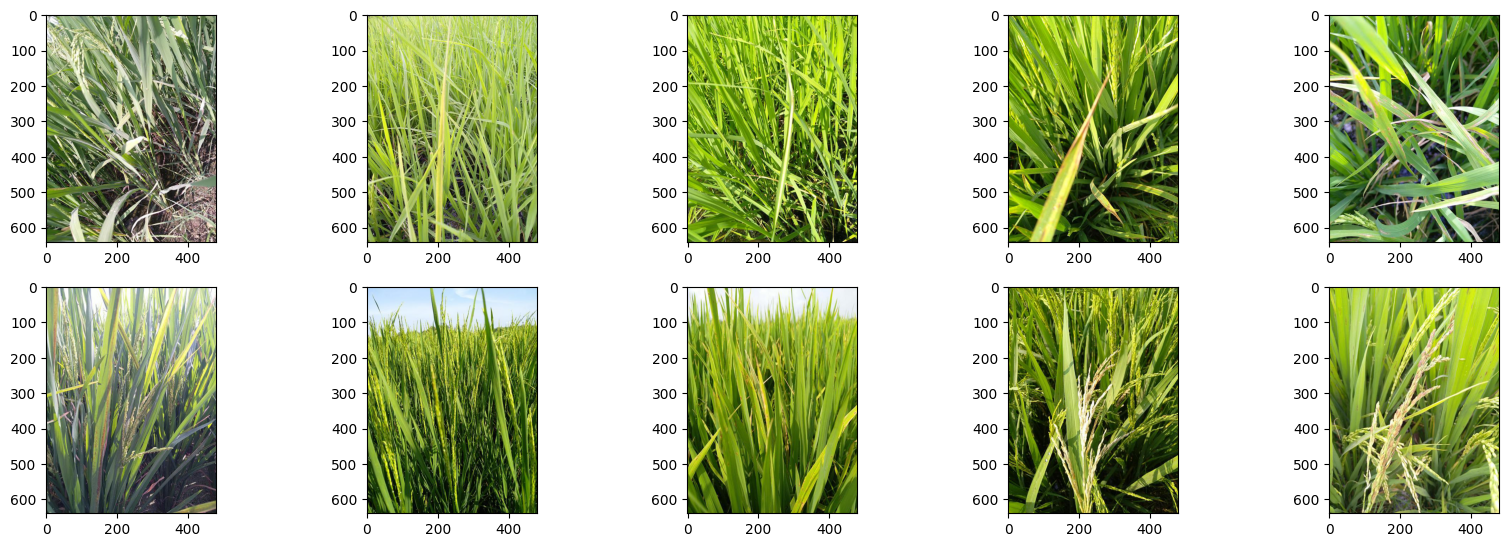

In [ ]:
plt.figure(figsize=(20,10))
cols = 5
for i, image_loc in enumerate(images):
  plt.subplot(len(images)//cols+1,cols,i+1)
  image = plt.imread(image_paths[i] + image_loc)
  plt.imshow(image)

Specifically with the diseases that affect the leaf, it is very difficult to discern the primary subject without segmentation. The hope is that the algorithm will not become lost in the background while searching for local patterns. Furthermore, some of the images in the random sample show such minimal effects of the disease that they almost appear healthy, which can be very misleading. Incorrectly diagnosing minimal symptoms can lead to huge yield loss later on. I further hope that by keeping a constant 3x3 windows for each convolutional layer, the small appearance variations between healthy and diseased can be picked up on by the network. 

Examine a subset of the above images, which are virtually undiscernable due to a combination of challenges mentioned perviously. 

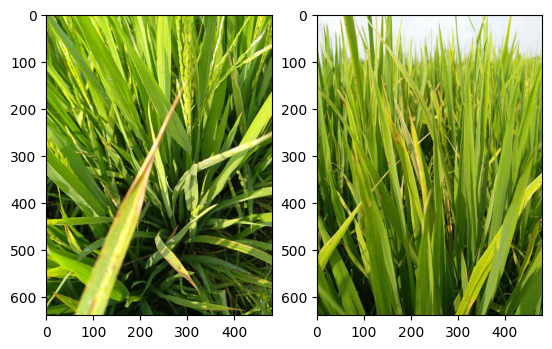

In [ ]:
plt.subplot(1,2,1)
image = plt.imread(image_paths[3] + images[3])
plt.imshow(image)

plt.subplot(1,2,2)
image = plt.imread(image_paths[7] + images[7])
plt.imshow(image)




For instance, it is unclear what the subject of the second image is, wince there is no leaf being held up to the camera. Furthermore, the foreground of the images is blurry, so any symptoms of disease are not immediately apparent. Thirdly, The greenness of the pictures overwhelm the image, and make it diffuclt to process what is being shown. 

# 4.1 Benchmark MobileNetV2 Model

To demonstrate benchmark effectiveness, I train a default MobileNetV2 model for 10 epochs. 

In [ ]:
img_size = 224
batch_size = 64

Pass our images through a two data generators, trainining and valdiation, in order to vectorize them for use in the model. We check that the generators worked by outputting how many images were found and in how many classes. For splitting, I use proportions of 80/10/10. (80% of the images are for training, 10% for validation, and 10% for testing). It is important to include the largest part for training so that the model may accurately learn the abstract features of the dataset. 

In [ ]:
labels = os.listdir('/content/RiceFinal/train')


train_data = image_dataset_from_directory(train_path,
                                          labels = 'inferred',
                                          class_names = labels,
                                          color_mode = 'rgb',
                                          seed = 42,
                                          batch_size = batch_size,
                                          image_size = (img_size, img_size),
                                          shuffle = True,
                                          label_mode = 'categorical'
                                          )

validation_data = image_dataset_from_directory(validation_path,
                                          labels = 'inferred',
                                          class_names = labels,
                                          color_mode = 'rgb',
                                          seed = 42,
                                          batch_size = batch_size,
                                          image_size = (img_size, img_size),
                                          shuffle = False,
                                          label_mode = 'categorical')

Found 8323 files belonging to 10 classes.
Found 1036 files belonging to 10 classes.


This is the desired result. from our overall dataset of 10,407 images, 8,323 are used for training and 1,036 are used for validation. 

In [ ]:
TUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.prefetch(buffer_size = TUNE)

In [ ]:
conv_base = MobileNetV2(input_shape = (img_size,img_size,3), include_top = False, weights = 'imagenet')
preprocessing_layer = mobilenet_v2.preprocess_input

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
def construct_model(conv_base, preprocessing_layer, input_size):
  input = Input(shape = (input_size, input_size, 3))
  model = RandomFlip(mode='horizontal')(input)
  model = preprocessing_layer(model)
  model = conv_base(model)

  model = Flatten()(model)
  model = Dense(1024, activation = 'relu')(model)
  model = BatchNormalization()(model)
  model = Dense(512, activation = 'relu')(model)
  model = BatchNormalization()(model)
  model = Dense(128, activation = 'relu')(model)
  model = Dropout(.25)(model)
  model = Dense(64, activation = 'relu')(model)
  model = Dropout(0.5)(model)
  model = BatchNormalization()(model)
  output = Dense(10, activation = 'softmax')(model)
  
  construct = Model(input, output)
  return construct


In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',patience=8, verbose=1,  factor=0.4, min_lr=0.0005)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=8, mode='auto', restore_best_weights=True, verbose=1)

checkpoint = ModelCheckpoint('model.hdf5', monitor='val_loss', save_best_only=True,verbose=1)

In [ ]:
model = construct_model(conv_base, preprocessing_layer, img_size)
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 2e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(train_data, validation_data = validation_data, epochs = 10, callbacks=[checkpoint,lr_reduction])

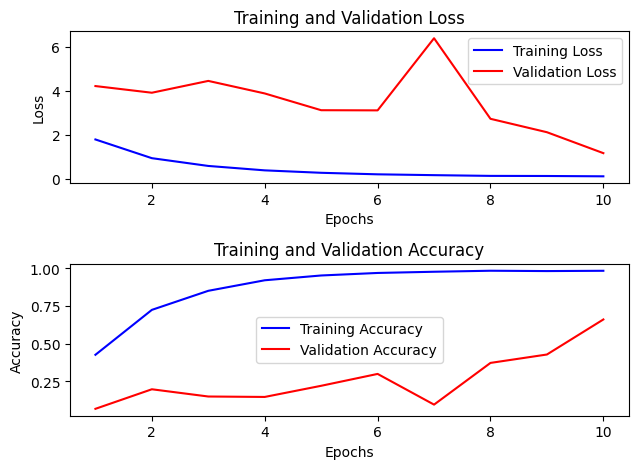

In [ ]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss)+1)


plt.subplot(2,1,1)
plt.plot(epochs, train_loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.subplot(2,1,2)
plt.plot(epochs, train_acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()


This model performs well, but not up to standards with the predictive power we are attempting to achieve. The discrepancy between training and valdiation accuracy is a common trait of overfitting, which means our model may be optimizing to the training data instead of generalizing to new data. In the next section I fine-tune the parameteres by un-freezing some of the top layers in the MobileNetV2 architecture and allowing them to train. Due to having an expanded model, I will also train it for more epochs. 

Also, the curves for validation accuracy are jagged, rather than smooth, which is further evidence towards overfitting.

# 4.2 Partially Unfrozen MobileNetV2 Model

In [ ]:
for layer in conv_base.layers[120:]:
  layer.trainable = True


In [ ]:
model_tuned = construct_model(conv_base, preprocessing_layer, img_size)
model_tuned.compile(
    optimizer= keras.optimizers.Adam(lr=2e-5),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history2 = model_tuned.fit(train_data, validation_data = validation_data, epochs = 30, callbacks=[checkpoint,lr_reduction])

Epoch 1/30
131/131 [==============================] - ETA: 0s - loss: 2.5740 - accuracy: 0.1826
Epoch 1: val_loss improved from inf to 2.18329, saving model to model.hdf5
131/131 [==============================] - 70s 392ms/step - loss: 2.5740 - accuracy: 0.1826 - val_loss: 2.1833 - val_accuracy: 0.2017 - lr: 2.0000e-05
Epoch 2/30
130/131 [============================>.] - ETA: 0s - loss: 2.0096 - accuracy: 0.3212
Epoch 2: val_loss improved from 2.18329 to 2.05740, saving model to model.hdf5
131/131 [==============================] - 45s 338ms/step - loss: 2.0098 - accuracy: 0.3210 - val_loss: 2.0574 - val_accuracy: 0.2703 - lr: 2.0000e-05
Epoch 3/30
130/131 [============================>.] - ETA: 0s - loss: 1.7336 - accuracy: 0.4129
Epoch 3: val_loss improved from 2.05740 to 2.03947, saving model to model.hdf5
131/131 [==============================] - 43s 322ms/step - loss: 1.7336 - accuracy: 0.4128 - val_loss: 2.0395 - val_accuracy: 0.2809 - lr: 2.0000e-05
Epoch 4/30
130/131 [======

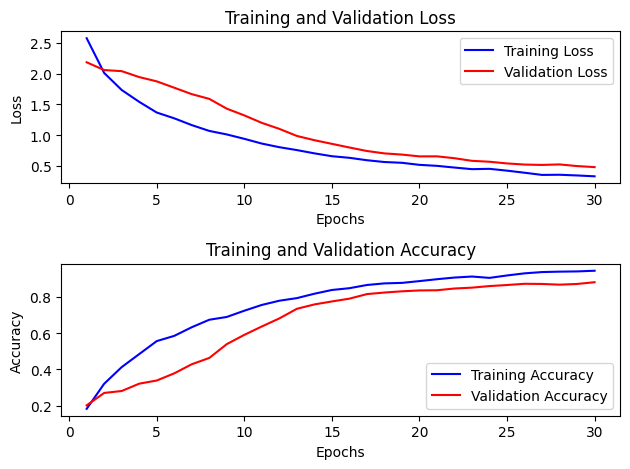

In [ ]:
train_loss = history2.history['loss']
train_acc = history2.history['accuracy']
val_loss = history2.history['val_loss']
val_acc = history2.history['val_accuracy']
epochs = range(1, len(train_loss)+1)


plt.subplot(2,1,1)
plt.plot(epochs, train_loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.subplot(2,1,2)
plt.plot(epochs, train_acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

As apparent from these metrics, the unfrozen model performs much better than the initial MobileNetV2 model, reaching a top validation accuracy of 88.13%. It thus follows that un-freezing the last 30 layers of the MobileNetV2 architecture allows it to excellently generalize to the data, preventing the overfitting experienced with the initial model. Furthermore, it appears that training the model for more than 20 epochs would generally continue to increase the performance accuracy.

Furthermore, both loss and accuracy curves are fairly smooth, which is a good indicator that the model is NOT overfitting to the training data. This is a good sign, because our model is making the generalization versus optimization tradeoff. By not overfitting to the trading data (optimization) it is able to better perform on eternal data (generalization), and thus produces better results when applied to data we care about. 

In [ ]:
model_tuned.save('RiceClassifier.h5')

# 5 Predictive Performance

The test dataset for this paper consists of 1048 images, once again distributed between 10 classes (9 diseased 1 healthy). However, the model will not be shown the true labels of this dataset, and will instead be asked to make predictions based on the abstract features it has learned during training. 

Based on the validation accuracy found earlier, I predict that the test accuracy should be somewhere in the range of 85-90%.

In [ ]:
test_dataset = image_dataset_from_directory(    
    '/content/RiceFinal/test',
    image_size = (img_size,img_size),
    batch_size = 64,
    shuffle=False,
    labels= 'inferred',
    class_names = labels,
    label_mode = 'categorical',
    color_mode='rgb'
)

Found 1048 files belonging to 10 classes.


In [ ]:
model_tuned.evaluate(test_dataset)

17/17 [==============================] - 3s 153ms/step - loss: 0.5268 - accuracy: 0.8731


[0.5268368124961853, 0.8730915784835815]

Using the baseline 'evaluate' command included in the Keras API, we see that the model performs with 87.31% accuracy on the test dataset. This is significant because it performs well on data it has not seen before, signifying that it did not overfit during training. Next, we will use the 'predict' function to see what exactly the model loses 12% accuracy on. Hopefully, we can get insight on how the aforementioned data challenges affect the model's performance. 

In [ ]:
predictions = model_tuned.predict(test_dataset)
predictions.shape

17/17 [==============================] - 4s 178ms/step


(1048, 10)

In [ ]:
uploaded = files.upload()

Saving test.csv to test (2).csv


In [ ]:
test_df = pd.read_csv('/content/test.csv')
test_df['pred'] = np.argmax(predictions, axis = -1)
test_df['pred'] = test_df['pred'].replace([0,1,2,3,4,5,6,7,8,9], labels)

In [ ]:
pred_acc = len(test_df[test_df['label'] == test_df['pred']])/len(test_df)

In [ ]:
print('{:.2%}'.format(pred_acc))

87.31%


As we can see, the prediction accuracy of the model is the same, which means it is acceptable to use the newly made dataframe containing true labels and predictions in the construction of a confusion matrix.

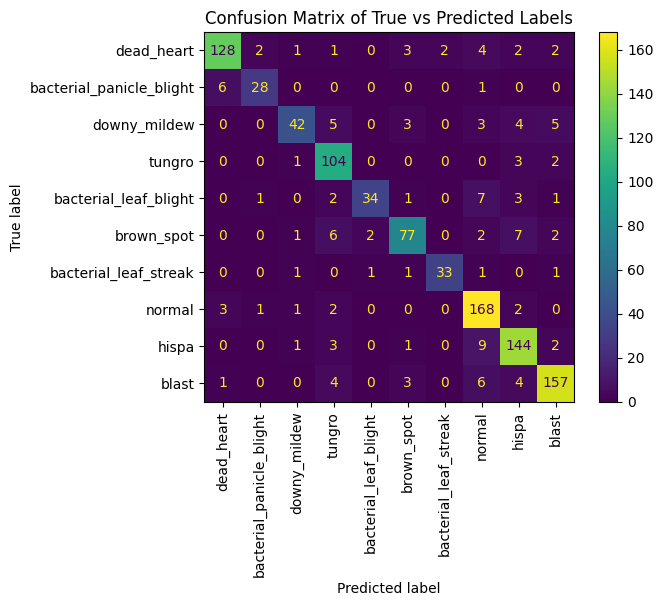

In [ ]:
cm_display = ConfusionMatrixDisplay.from_predictions(test_df['label'],test_df['pred'],labels = labels, xticks_rotation = 'vertical') 
plt.title('Confusion Matrix of True vs Predicted Labels')
plt.show()

(While the predicted labels are unreadable due to sklearn's default display, it can nevertheless be ascertained that predicted labels from left to right match the true labels from top to bottom)

We can see that the model does not often misclassify diseases, with the maximum number of errors across classes being 7 (between blast and normal rice). This, of course, is an example of a challenge mentioned during the EDA section of this paper. Since syptoms of blast are not overly prominent, coupled with poor focus in the photographs, the algorithm had 7 cases of misclassifying blast as healthy rice.

In general, the model had the most issues with false negatives , which made up a rather large proportion of its misclassified images. This is a rather serious issue, which can once again be attributed to the inconsistencies found in the dataset. This being said, of the test set of 1048 images, False Negatives made up only 30 cases.  (False Positives made up only 7 total cases across all diseases). This being said, the test is still both sensitive and specific when the overall accuracy is considered. 

Despite challenges with the data, the algorithm still performed very well in correctly labelling the majority of the diseases. This implies that the convolutional network automatically performs segmentation and is able to somewhat disregard the background when assessing diseases subjects. Furthermore, the blurry images did not seem to pose much of an issue, as the algorithm picked up on important pixel values and formed a working spatial hierarchy regardless of the resolution. 

# 6 Discussion and Conclusion

As becomes apparent from the previous sections, the convolutional neural network approach to the diagnosis and classification of disease in rice plants proved to be quite effective.

With a final test accuracy of 88.26% the model demonstrated its ability to quickly AND accurately diagnose diseases. While a human expert may be able to more accurately diagnose rice illness, this is time consuming, and experts in such a field are extremely limited. Meanwhile, the unfrozen model constructed and trained earlier is able to make preditions instantaneously, and could be widely deployed without issue. Interestingly enough, when compared to formal research, the model created here does not perform much worse! For example, the ensemble model created by (Deng, Tao, et al., 2021) reached an overall accuracy of 91% in diagnosing 6 types of diseases [[8]](https://www.frontiersin.org/articles/10.3389/fpls.2021.701038/full). 

In regards to the challenges put forth during exploratory data analysis:
The convolutional netwrok was able to handle the challenges automatically, without significantly affecting its performance. This implies that the algorithm either does not take the challenges into account, like humans do, or simply resolves it by itself during data preprocessing. 

Comments on increasing accuracy:
If more time and computing resources were available, the performance of the model could be further boosted. That is, training for more epochs would most definitely increase test accuracy, since my model was only trained on 20 epochs and validation/training accuracy never decreased. Furthermore, usage of larger images may or may not increase performance. Generally,CNNs perform best on images of up to 256x256 depending on the architecture. This model was created and trained on 224x224, the standard image size MobileNetV2 expects. Of course, there is room to near endlessly tune hyperparameter values to marginally increase performance. 

To conclude: the convolutional neural netwrok approach has proved itself to be a powerful, independent tool for image classification, avoiding the many pitfalls of old densely connected networks. It does not rely on heavily preprocessed image data (needing only image resizing and pixel value normalization). Furthermore, the model created for the purpose of this paper is rather lightweight, being only 250 megabytes when compressed as a TFLite h5 weight file. This small size makes it perfect for mobile deployment, further increasing its accessibility.



# Appendix [WIP]

# Acknowledgements

1. [Rice Nutrition Information](https://www.usarice.com/thinkrice/health-nutrition/rice-nutrition)
2. [Rice Importance for Global Nutrition](https://pubmed.ncbi.nlm.nih.gov/31619630/)
3. [Rice Diseases](http://www.knowledgebank.irri.org/step-by-step-production/growth/pests-and-diseases/diseases)
4. [Basal Rice information including common diseases](https://plantvillage.psu.edu/topics/rice/infos)
5. [Rice Diseases of India](https://www.intechopen.com/chapters/79212)
6. [Geographic Rice Sectors](https://www.ers.usda.gov/topics/crops/rice/rice-sector-at-a-glance/)
7. [Rice Disease Diagnosis with ML](https://link.springer.com/article/10.1007/s42452-022-05194-7)
8. [Ding, Tao, et al., 2021](https://www.frontiersin.org/articles/10.3389/fpls.2021.701038/full)


